In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as T
from Data_Loader import CaptionDataset


In [40]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(data):
    # data is a list of tuples: (image_tensor, caption_tensor)
    images, captions = zip(*data)
    
    # Stack images as normal (all images same shape)
    images = torch.stack(images, 0)
    
    # Pad captions to max length in the batch
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)  # assuming 0 is your <PAD> index
    
    return images, captions_padded


In [41]:
data_location=r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data"
BATCH_SIZE=256
NUM_WORKER=4

transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


dataset =  CaptionDataset(
    root_dir = data_location+"/Images",
    file= data_location+"/captions.txt",
    transform=transforms
)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    #collate_fn=CapsCollate(pad_idx=dataset.vocab.stoi["<PAD>"])
    collate_fn=collate_fn
)
vocab_size = len(dataset.vocab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [ ]:
# # location="C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data"
# # batch_size=256
# # num_worker=4

# import pandas as pd
# import os
# from PIL import Image


# class ImageCaptionDataset(Dataset):
#     def __init__(self, txt_file, image_dir, transform=None):
#         # Load .txt file as CSV
#         self.df = pd.read_csv(txt_file, delimiter=',', names=["image", "caption"], skiprows=1)
#         self.image_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         image_name = self.df.loc[idx, 'image']
#         caption = self.df.loc[idx, 'caption']

#         image_path = os.path.join(self.image_dir, image_name)
#         image = Image.open(image_path).convert("RGB")

#         if self.transform:
#             image = self.transform(image)

#         return image, caption

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize(226),
#     transforms.RandomCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406),
#                          (0.229, 0.224, 0.225))
# ])

# dataset = ImageCaptionDataset(
#     txt_file=r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data\captions.txt",
#     image_dir=r"C:\Users\OMEN\Documents\PYTORCH\IMAGE_CAPTIONING\data\Images",
#     transform=transform
# )


In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [43]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
                    param.requires_grad_(False)  # Freeze all weights

        modules = list(resnet.children())[:-2]  # Remove avgpool + fc
        self.resnet = nn.Sequential(*modules)

    def forward(self,images):
           features=self.resnet(images)
           features=features.permute(0,2,3,1)
           features = features.view(features.size(0), -1, features.size(-1))
           return features

In [44]:
class BahdanauAttention(nn.Module):
    def __init__(self,encoder_dim,decoder_dim,attention_dim):
        super(BahdanauAttention,self).__init__()

        self.encoder_attn=nn.Linear(encoder_dim,attention_dim)
        self.decoder_attn=nn.Linear(decoder_dim,attention_dim)
        self.full_attn = nn.Linear(attention_dim, 1) 


    def forward(self,encoder_outputs,decoder_hidden):

        """
        encoder_outputs: [batch_size, seq_len, encoder_dim]
        decoder_hidden : [batch_size, decoder_dim]
        """

        encoder_proj = self.encoder_attn(encoder_outputs)           
        decoder_proj = self.decoder_attn(decoder_hidden)            
        decoder_proj = decoder_proj.unsqueeze(1)                    

        combined = torch.tanh(encoder_proj + decoder_proj)          

        scores = self.full_attn(combined).squeeze(2)                

        alpha = F.softmax(scores, dim=1)                            

        context = torch.sum(encoder_outputs * alpha.unsqueeze(2), dim=1)  

        return alpha, context

In [45]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = BahdanauAttention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds=self.embedding(captions)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.itos[idx] for idx in captions],alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [46]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [47]:
#Hyperparameters
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [48]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\OMEN\Documents\PYTORCH\envpy\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\OMEN\Documents\PYTORCH\envpy\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [50]:
def show_image(img,title=None):
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Epoch: 1 loss: 4.32912


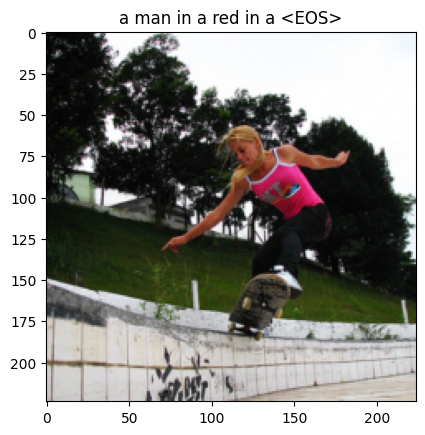

Epoch: 2 loss: 3.67114


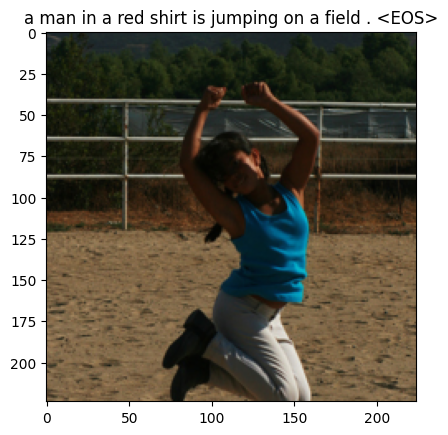

Epoch: 3 loss: 3.40977


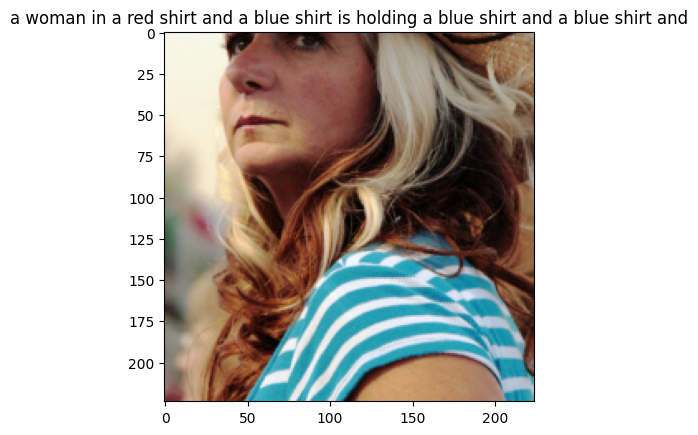

Epoch: 4 loss: 3.15218


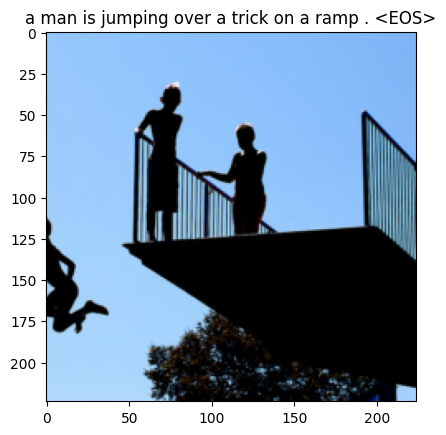

Epoch: 5 loss: 3.01041


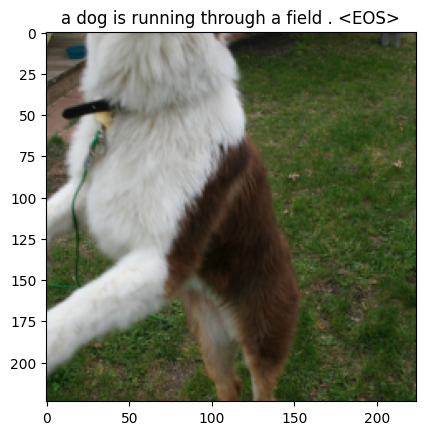

Epoch: 6 loss: 2.91466


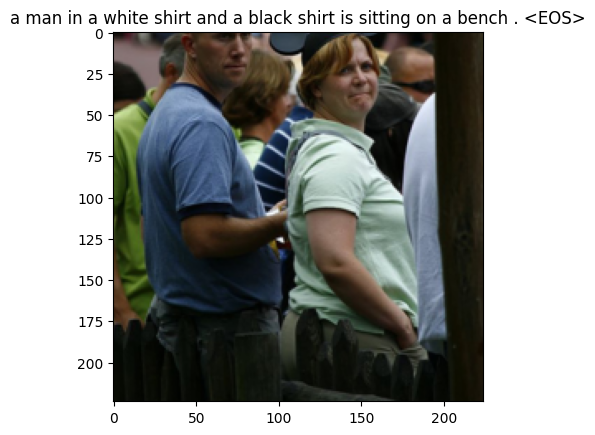

Epoch: 7 loss: 2.78559


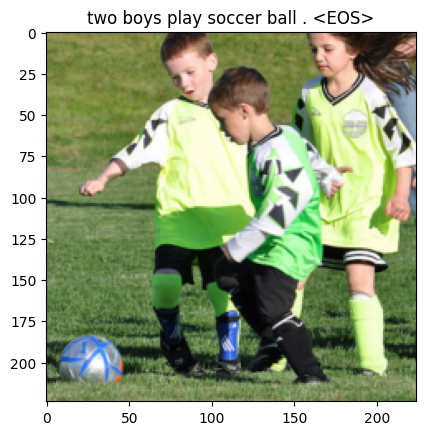

Epoch: 8 loss: 2.78029


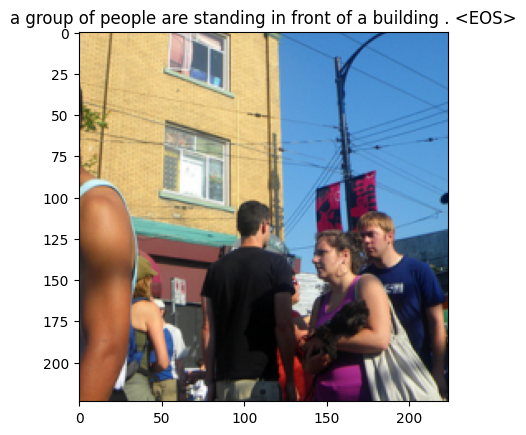

Epoch: 9 loss: 2.75175


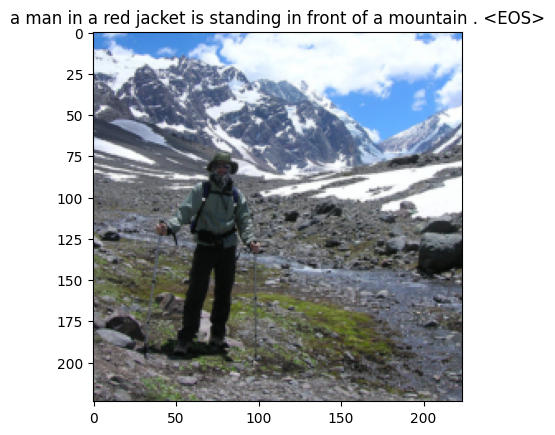

Epoch: 10 loss: 2.62986


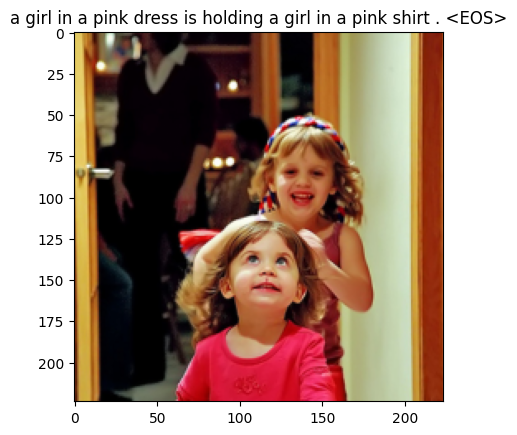

Epoch: 11 loss: 2.53256


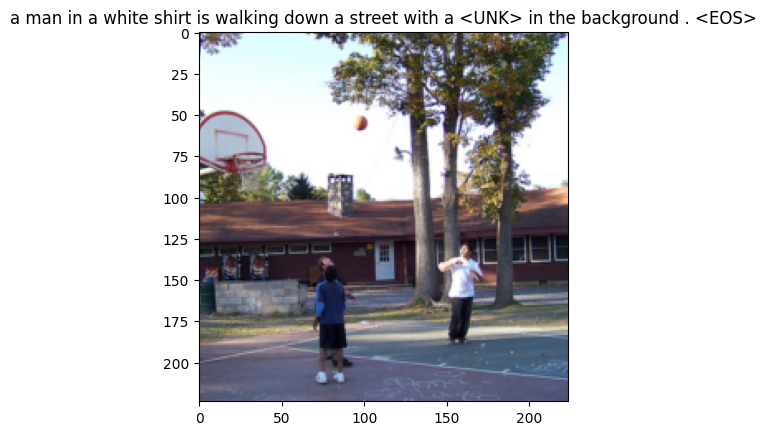

Epoch: 12 loss: 2.56485


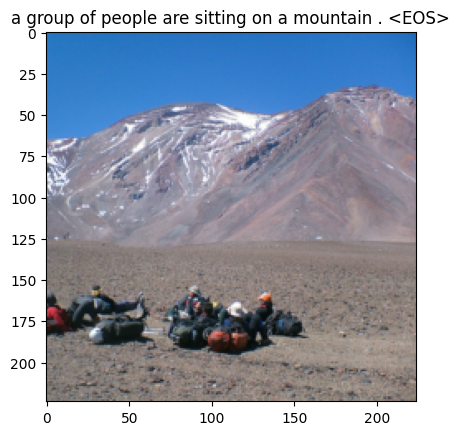

Epoch: 13 loss: 2.43037


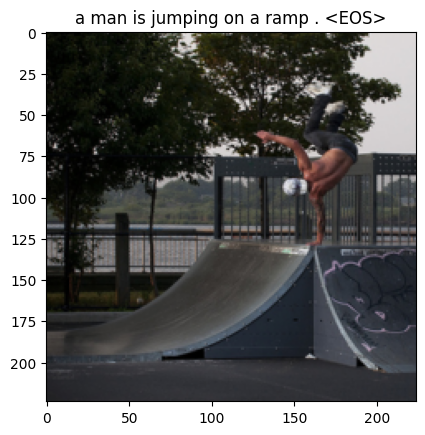

Epoch: 14 loss: 2.47824


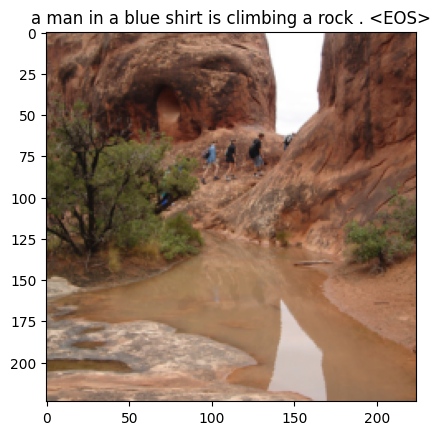

Epoch: 15 loss: 2.28812


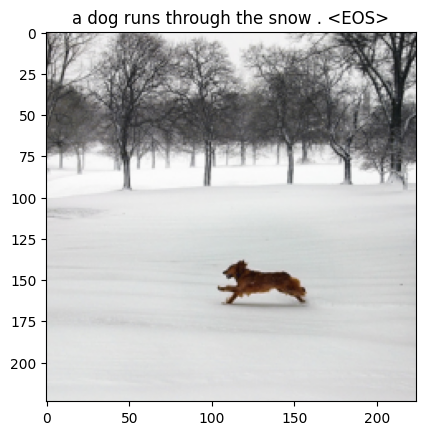

In [51]:
num_epochs=15
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)


        optimizer.zero_grad()

        outputs,attentions = model(image, captions)

        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    save_model(model,epoch)
